In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import pickle 
import cortex
from dag_prf_utils.pycortex import *

import sys
import nibabel as nib
from nibabel.freesurfer.io import read_morph_data, write_morph_data
import cortex

In [29]:
subj = 'sub-34'
subjectid='sub-34'
subject = subjectid
depth='GM'
project='PROJECT_EGRET-AAA'
space='fsnative'
roi=['all']
r2_thr=0.1
target_visual_area = 3
source_visual_area = 1
file_path = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/{subj}/V{target_visual_area}->V{source_visual_area}/best_fits.csv'  # Update with the actual path to your CSV file
MAIN_PATH = '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives'
hemi = 'lh'
delineation = 'manualdelin'
labels_path = f"{MAIN_PATH}/freesurfer/{subj}/label/{hemi}.{delineation}.label"
data = pd.read_csv(file_path)
atlas = 'manual'
denoising = 'nordic'
task = 'RET'
fs_dir = f"{MAIN_PATH}/freesurfer"

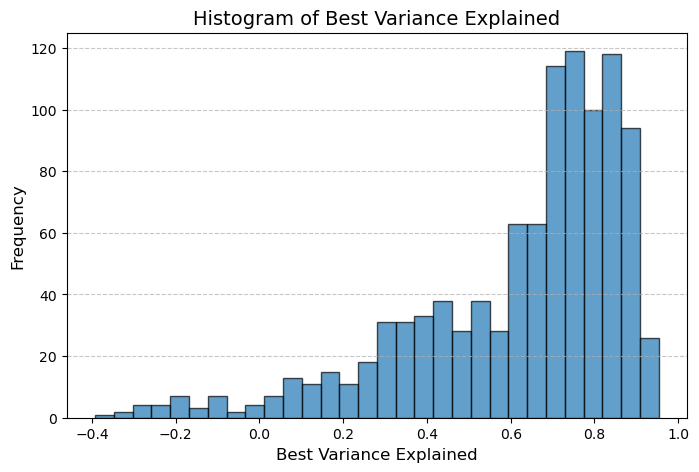

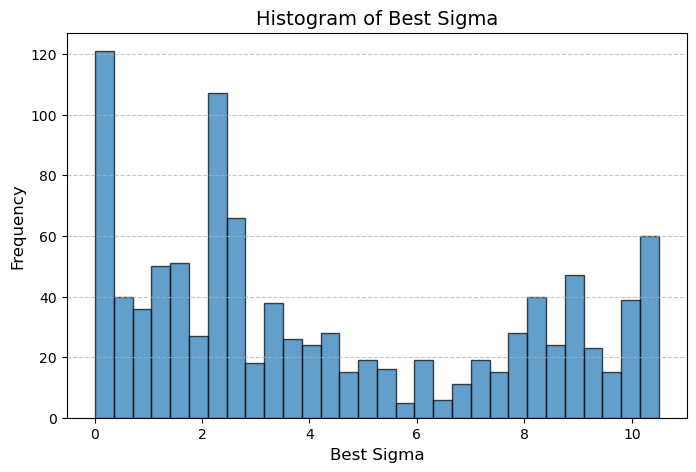

Number of unique values in 'Target Vertex Index': 1031


In [30]:
### VARIANCE EXPLAINED FREQUENCY 
plt.figure(figsize=(8, 5))
plt.hist(data['Best Variance Explained'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Histogram of Best Variance Explained', fontsize=14)
plt.xlabel('Best Variance Explained', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### SIGMA FREQUENCY 
plt.figure(figsize=(8, 5))
plt.hist(data['Best Sigma'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Histogram of Best Sigma', fontsize=14)
plt.xlabel('Best Sigma', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### TARGET INDICES
target_values = data['Target Vertex Index'].nunique()
print(f"Number of unique values in 'Target Vertex Index': {target_values}")

In [31]:
### EXTRACT ECCENTRICITY AND POLAR ANGLE 

class PRFModel:
    '''Class representing pRF model parameters '''
    def __init__(self, r2, size, ecc, angle):
        """
        Initialize the PRFModel instance with the following parameters:
            
        Parameters:
        r2 (float): Model fit value (R-squared). Represents how well the model explains the variance in the observed data. 
                    A higher value indicates a better fit.
        size (float): Size of the pRF (population receptive field), which describes the spatial extent or diameter of the receptive field.
        ecc (float): Eccentricity. Represents the distance of the pRF from the center of the visual field. Higher values mean the receptive field 
                    is located farther from the center (fovea).
        angle (float): Polar angle. Specifies the direction of the receptive field from the center, often in degrees or radians.
        """
        self.r2 = r2            # Model fit - represents how well the model explains data variance
        self.size = size        # Size of the pRF (population receptive field)
        self.ecc = ecc          # Eccentricity - distance of the pRF from the center
        self.angle = angle      # Polar angle - position angle of the pRF

def load_pickle_file(filepath):
    '''Function to load a pickle file given a file path'''
    # Check if the given file path points to an existing file
    if not os.path.isfile(filepath):
        # If the file does not exist, raise a FileNotFoundError
        raise FileNotFoundError(f"File not found: {filepath}")
    # Open the file in 'rb' mode (read binary) since pickle files contain serialized binary data
    with open(filepath, 'rb') as file: 
        # Deserializes the contents of the binary file and returns the Python object.
        return pickle.load(file)

def load_prf_params(subjectid, main_path, atlas, denoising, task):
    '''Function to load pRF parameters for a given subjects and other details'''
    # Construct the file path to the pRF parameters file based on input parameters
    # The path points to a pickle file that contains the pRF model information
    filepath = os.path.join(main_path, f'pRFM/{subjectid}/ses-02/{denoising}/model-{atlas}-nelder-mead-GM_desc-prf_params_{task}.pkl') 
    # Load the pickle file using the load_pickle_file function defined previously
    pkl_data = load_pickle_file(filepath)                       
    # Extract the pRF model parameters using the 'iterative_search_params' key from the loaded data
    prf_params = pkl_data['model'].iterative_search_params     
    # Extract the indices of the voxels that fall within the region of interest (ROI) 
    # This is done by finding where the 'rois_mask' is equal to 1 (indicating the voxel is inside the ROI)
    prf_voxels = np.where(pkl_data['rois_mask'] == 1)[0]      
    # Return both the extracted pRF model parameters and the indices of the voxels within the ROI
    return prf_params, prf_voxels

def filter_prf_data(prf_params, prf_voxels):
    '''Filter and extract pRF data for the selected voxels'''
    # Construct and return a PRFModel object containing specific parameters of interest
    # - r2, size, eccentricity, and polar angle for the selected voxels.
    return PRFModel(
        r2=prf_params[:, 7],                                                # Extract R2 values from column 7 of prf_params.
        size=prf_params[:, 2],                                              # Extract pRF size values from column 2 of prf_params.
        # Eccentricity is calculated as the Euclidean distance from the center (0,0)
        # This is done using the Pythagorean theorem: ecc = sqrt(x^2 + y^2).
        ecc=np.sqrt(prf_params[:, 1]**2 + prf_params[:, 0]**2),             # Calculate eccentricity 
        # np.arctan2(y, x) computes the angle (in radians) of the vector formed by (x, y) relative to the positive x-axis.
        # The function np.rad2deg() converts the resulting angle to degrees.
        angle=np.rad2deg(np.arctan2(prf_params[:, 1], prf_params[:, 0]))    # Calculate polar angle
    )

def load_labels(subjectid, main_path, atlas):
    '''Function to load FreeSurfer labels for the specified subject'''
    # Define the path to the FreeSurfer directory within the main project directory
    fs_dir = os.path.join(main_path, 'freesurfer') 
    try:
        # Load label indices for visual areas and eccentricity regions:
        # Load visual area labels (V1, V2, V3, etc.) using Benson's visual area label ('benson14_varea-0001')
        idx_rois4, idx_vls4 = cortex.freesurfer.get_label(subjectid, label='benson14_varea-0001', fs_dir=fs_dir, hemisphere=('lh', 'rh'))
        # Load eccentricity labels using Benson's eccentricity label ('benson14_eccen-0001')
        idx_rois1, idx_vls1 = cortex.freesurfer.get_label(subjectid, label='benson14_eccen-0001', fs_dir=fs_dir, hemisphere=('lh', 'rh'))
        # Check if 'manual' atlas is specified
        # If a manual atlas is requested, load the manual labels and update the corresponding indices
        if atlas == 'manual': 
            idx_rois_manual, idx_vls_manual = cortex.freesurfer.get_label(subjectid, label='manualdelin', fs_dir=fs_dir, hemisphere=('lh', 'rh'))
            # Update the values in idx_vls4 to use the manual labels wherever applicable
            idx_vls4[idx_rois_manual] = idx_vls_manual
    except Exception as e:
        # If there is an error loading any of the labels, raise a RuntimeError
        raise RuntimeError(f"Error loading labels for subject {subjectid}: {e}")
    # Return the loaded indices and values:
    # - idx_rois4, idx_vls4: Visual area indices and labels
    # - idx_vls1: Eccentricity labels
    return idx_rois4, idx_vls4, idx_vls1

def extract_prf_properties(subj, main_path, atlas, denoising, task, csv_path):
    data = pd.read_csv(csv_path) # Load the best fits data
    prf_params, prf_voxels = load_prf_params(subj, main_path, atlas, denoising, task) # Load pRF parameters
    prf_data = filter_prf_data(prf_params, prf_voxels) # Filter the loaded pRF parameters

    # Create a mapping of voxel index to eccentricity and polar angle
    voxel_to_ecc = dict(zip(prf_voxels, prf_data.ecc)) # All the voxels: All the eccentricities
    voxel_to_angle = dict(zip(prf_voxels, prf_data.angle)) # All the voxels: All the polar angles

    # Extract the corresponding pRF properties
    data['Eccentricity'] = data['Source Vertex Index'].map(voxel_to_ecc) # 
    print(data.shape)
    data['Polar Angle'] = data['Source Vertex Index'].map(voxel_to_angle)

    # Save the new dataframe with extracted pRF properties
    output_csv_path = os.path.join(os.path.dirname(csv_path), 'best_fits_with_prf.csv')
    data.to_csv(output_csv_path, index=False)
    print(f"Updated file saved at: {output_csv_path}")
    return data

updated_data = extract_prf_properties(subj, MAIN_PATH, atlas, denoising, task, file_path)

updated_data

(1033, 5)
Updated file saved at: /Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/sub-34/V3->V1/best_fits_with_prf.csv


,Target Vertex Index,Source Vertex Index,Best Sigma,Best Variance Explained,Eccentricity,Polar Angle
0,116220.0,5322.0,7.074694,0.757135,7.799729,9.172328
1,9979.0,5324.0,3.221224,0.685421,7.718486,-3.966481
2,9978.0,5322.0,6.860612,0.776119,7.799729,9.172328
3,9970.0,408.0,8.145102,0.743961,0.954852,-2.240114
4,9980.0,408.0,3.435306,0.679716,0.954852,-2.240114
...,...,...,...,...,...,...
1028,655.0,7719.0,0.010000,0.297982,10.823977,45.347526
1029,113611.0,3418.0,0.010000,0.615215,0.000000,0.000000
1030,106833.0,429.0,8.359184,0.074012,1.081279,-21.991844
1031,116220.0,5322.0,7.043799,0.757130,7.799729,9.172328


In [32]:
## MARCUS 
updated_data
v1_ecc = np.zeros(pm.total_n_vx)
v1_ecc[updated_data['Source Vertex Index'].astype(int)] = updated_data['Eccentricity']
v1_ecc

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
## MARCUS 
pm = PyctxMaker(
    sub=subj,
    fs_dir=fs_dir)

Using fs dir = /Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer
/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/pycortex
default
/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/pycortex/sub-34


flat
{'cmap': 'viridis', 'vmin': 0.5322311254520338, 'vmax': 10.82397677864228}


{'cmap': 'viridis', 'vmin': 0.5322311254520338, 'vmax': 10.82397677864228}

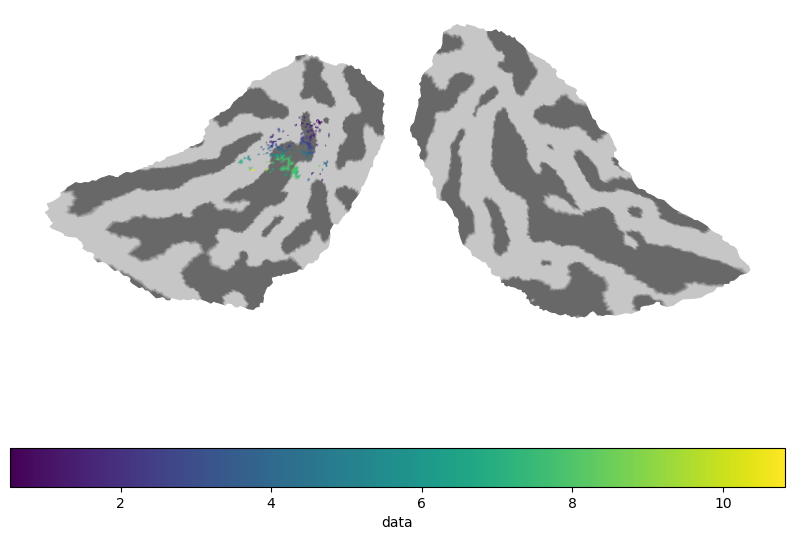

In [34]:
## MARCUS 
pm.flat_mpl(data=v1_ecc, data_mask=v1_ecc!=0)

In [64]:
prf_results = np.load(f'{MAIN_PATH}/pRFM/{subjectid}/ses-02/{denoising}/model-{atlas}-nelder-mead-GM_desc-prf_params_{task}.pkl', allow_pickle=True) 
roi_verts = np.where(prf_results['rois_mask'] == 1)
prf_results = prf_results['model'].iterative_search_params
best_fits_path = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/{subj}/V{target_visual_area}->V{source_visual_area}/best_fits.csv'
best_fits_data = pd.read_csv(best_fits_path)

# Extract the parameters 
prf_params_vx = roi_verts[0]
size = prf_results[:, 2]
angle_map = cortex.Vertex.empty(f'{subj}')

masked_polar_angle = np.zeros(angle_map.nverts)
masked_polar_angle[:] = 50
masked_eccentricity = np.zeros(angle_map.nverts)
masked_eccentricity[:] = 50
masked_r2 = np.zeros(angle_map.nverts)
masked_r2[:] = 0.05
masked_radius = np.zeros(angle_map.nverts)
masked_radius[:] = 50

# Extract the actual measurements
eccentricity = np.sqrt(prf_results[:, 0]**2 + prf_results[:, 1]**2)
polar_angle = np.arctan2(prf_results[:, 1], prf_results[:, 0])
r2 = data['Best Variance Explained']
print(r2)
r2 = prf_results[:, -1] ### THIS NEEDS TO BE CHANGED as it is based on pRF mapping
print(r2)
### Here instead store the Best Variance Explained values fromt he best_fits.csv file. 
#sigma = data['Best Variance Explained']
#sigma = data['Best Variance Explained']
#print(sigma[1])

# Masking
r2_mask = r2 > 0.01
ecc_mask = eccentricity < 20
total_mask = r2_mask * ecc_mask 

polar_angle[total_mask == False] = 50
eccentricity[total_mask == False] = 50
r2[total_mask == False] = 0
size[total_mask == False] = 50

masked_polar_angle[roi_verts] = polar_angle
masked_eccentricity[roi_verts] = eccentricity
masked_r2[roi_verts] = r2
masked_radius[roi_verts] = size

"""
# Create the necessary files for the visualization 
lh_c = read_morph_data(f'{fs_dir}/{subj}/lh.curv')
lh_masked_pol = masked_polar_angle[:lh_c.shape[0]]
rh_masked_pol = masked_polar_angle[lh_c.shape[0]:]
lh_masked_ecc = masked_eccentricity[:lh_c.shape[0]]
rh_masked_ecc = masked_eccentricity[lh_c.shape[0]:]
lh_masked_r2 = masked_r2[:lh_c.shape[0]]
rh_masked_r2 = masked_r2[lh_c.shape[0]:]
lh_masked_radius = masked_radius[:lh_c.shape[0]]
rh_masked_radius = masked_radius[lh_c.shape[0]:]

# Conditional file naming based on the atlas type

write_morph_data(f'{fs_dir}/lh.masked_pol_manual_{task}', lh_masked_pol)
write_morph_data(f'{fs_dir}/rh.masked_pol_manual_{task}', rh_masked_pol)
write_morph_data(f'{fs_dir}/lh.masked_ecc_manual_{task}', lh_masked_ecc)
write_morph_data(f'{fs_dir}/rh.masked_ecc_manual_{task}', rh_masked_ecc)
write_morph_data(f'{fs_dir}/lh.masked_r2_manual_{task}', lh_masked_r2)
write_morph_data(f'{fs_dir}/rh.masked_r2_manual_{task}', rh_masked_r2)
write_morph_data(f'{fs_dir}/lh.masked_radius_manual_{task}', lh_masked_radius)
write_morph_data(f'{fs_dir}/rh.masked_radius_manual_{task}', rh_masked_radius)"""

0       0.757135
1       0.685421
2       0.776119
3       0.743961
4       0.679716
          ...   
1028    0.297982
1029    0.615215
1030    0.074012
1031    0.757130
1032    0.757152
Name: Best Variance Explained, Length: 1033, dtype: float64
[0.28011348 0.43177242 0.60080354 ... 0.17097509 0.15136271 0.71672951]


"\n# Create the necessary files for the visualization \nlh_c = read_morph_data(f'{fs_dir}/{subj}/lh.curv')\nlh_masked_pol = masked_polar_angle[:lh_c.shape[0]]\nrh_masked_pol = masked_polar_angle[lh_c.shape[0]:]\nlh_masked_ecc = masked_eccentricity[:lh_c.shape[0]]\nrh_masked_ecc = masked_eccentricity[lh_c.shape[0]:]\nlh_masked_r2 = masked_r2[:lh_c.shape[0]]\nrh_masked_r2 = masked_r2[lh_c.shape[0]:]\nlh_masked_radius = masked_radius[:lh_c.shape[0]]\nrh_masked_radius = masked_radius[lh_c.shape[0]:]\n\n# Conditional file naming based on the atlas type\n\nwrite_morph_data(f'{fs_dir}/lh.masked_pol_manual_{task}', lh_masked_pol)\nwrite_morph_data(f'{fs_dir}/rh.masked_pol_manual_{task}', rh_masked_pol)\nwrite_morph_data(f'{fs_dir}/lh.masked_ecc_manual_{task}', lh_masked_ecc)\nwrite_morph_data(f'{fs_dir}/rh.masked_ecc_manual_{task}', rh_masked_ecc)\nwrite_morph_data(f'{fs_dir}/lh.masked_r2_manual_{task}', lh_masked_r2)\nwrite_morph_data(f'{fs_dir}/rh.masked_r2_manual_{task}', rh_masked_r2)\nwri